In [1]:
# Regularization: Ridge, LASSO, Elastic Net
# based on D. Bette that was based on J. Nagler
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

### Define models

In [2]:
# Min: ||y - Xw||^2_2 + alpha * ||w||^2_2
def do_ridge(lambdaaa,X_train,y_train,X_test,y_test):
    ridge = Ridge(alpha=lambdaaa, max_iter=int(10e5))
    ridge.fit(X_train,y_train)
    ridge_train_score=ridge.score(X_train,y_train)
    ridge_test_score=ridge.score(X_test,y_test)
    ridge_num_features = np.sum(ridge.coef_!=0)
    ridge_coef = ridge.coef_
    return [round(lambdaaa, 4), round(ridge_train_score, 4), round(ridge_test_score, 4), ridge_num_features], list(ridge_coef)

# Min: cN ||y - Xw||^2_2 + alpha * ||w||_1
def do_lasso(lambdaaa,X_train,y_train,X_test,y_test): #do not use "lambda" as variable
    lasso = Lasso( alpha=lambdaaa )
    lasso.fit( X_train,y_train )
    lasso_train_score=lasso.score( X_train,y_train )
    lasso_test_score=lasso.score( X_test,y_test )
    lasso_num_features = np.sum( lasso.coef_!=0 )
    lasso_coef = lasso.coef_
    return [round(lambdaaa, 4), round(lasso_train_score, 4), round(lasso_test_score, 4), lasso_num_features], list(lasso_coef)

# Min: cN ||y - Xw||^2_2 + c1 ||w||_1 + c2 ||w||^2_2
def do_elastic(lambdaaa,X_train,y_train,X_test,y_test):
    elast = ElasticNet(alpha=lambdaaa, l1_ratio=0.5, max_iter=int(10e5)) # L1-Ratio is set to fixed value for comparison
    elast.fit(X_train,y_train)
    elast_train_score=elast.score(X_train,y_train)
    elast_test_score=elast.score(X_test,y_test)
    elast_num_features = np.sum(elast.coef_!=0)
    elast_coef = elast.coef_
    return [round(lambdaaa, 4), round(elast_train_score, 4), round(elast_test_score, 4), elast_num_features], list(elast_coef)

In [12]:
#package 

def compare(X,y,feature_names):
    #X = pd.get_dummies(X)
    # Split data into train and test datasets and use statify sampling
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2,
                                                        #stratify=y, 
                                                        random_state=42)
    
    sc = MinMaxScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    results, coefficient = [], []

    for i in np.logspace(-4, np.log10(1), 100):   
        run, coef_run = do_lasso(i,X_train,y_train,X_test,y_test)
        results.append(run)
        coefficient.append(coef_run)
    temp_1,temp_2 = [],[]
    temp_1 = pd.DataFrame(results, columns=["Lambda", "Train Score", "Test Score", "Number of features"])
    temp_2 = pd.DataFrame(coefficient, columns=feature_names)
    lasso_results = pd.concat([temp_1, temp_2], axis=1)

    results, coefficient = [], []

    for i in np.logspace(-4, np.log10(1), 100):    
        run, coef_run = do_ridge(i,X_train,y_train,X_test,y_test)
        results.append(run)
        coefficient.append(coef_run)

    temp_1 = pd.DataFrame(results, columns=["Lambda", "Train Score", "Test Score", "Number of features"])
    temp_2 = pd.DataFrame(coefficient, columns=feature_names)
    ridge_results = pd.concat([temp_1, temp_2], axis=1)   

    results, coefficient = [], []

    for i in  np.logspace(-4, np.log10(1), 100):     
        run, coef_run = do_elastic(i,X_train,y_train,X_test,y_test)
        results.append(run)
        coefficient.append(coef_run)

    temp_1 = pd.DataFrame(results, columns=["Lambda", "Train Score", "Test Score", "Number of features"])
    temp_2 = pd.DataFrame(coefficient, columns=feature_names)
    elastic_results = pd.concat([temp_1, temp_2], axis=1)

    elastic_cv = ElasticNetCV(l1_ratio=np.linspace(0.001, 0.999, num=10), 
                            n_alphas=100,
                            cv=10, 
                            random_state=42)

    elastic_cv.fit(X_train,y_train)
    elastic_cv_train_score=round(elastic_cv.score(X_train,y_train), 4)
    elastic_cv_test_score=round(elastic_cv.score(X_test,y_test), 4)
    elastic_cv_num_features = np.sum(elastic_cv.coef_!=0)
    lambda1 = round(elastic_cv.alpha_, 4)

    plot_names = ["LASSO", "RIDGE", "ElasticNet"]
    plot_data = [lasso_results, ridge_results, elastic_results]

    plt.figure(figsize=(18, 6))
    for i in range(0,3):
        name = plot_names[i]
        data = plot_data[i]
        plt.subplot(1, 3, i+1)
        if i == 2:
            plt.plot(np.ones(5)*lambda1,np.linspace(0,1,5),label= "cv lambda")
        plt.plot(data["Lambda"], data["Train Score"], label="Train Score")
        plt.plot(data["Lambda"], data["Test Score"], label="Test Score")
        plt.xlabel("Lambda")
        plt.ylabel("Score")
        #plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.xscale('log')
        plt.legend()
        plt.title(name)
    plt.show()

    plot_names = ["LASSO", "RIDGE", "ElasticNet"]
    plot_data = [lasso_results, ridge_results, elastic_results]

    plt.figure(figsize=(12, 6))
    for i in range(1,3):
        plt.subplot(1,2,i)
        for name, data in zip(plot_names, plot_data):
            plt.plot(data["Lambda"], data["Number of features"], label=name)    
        plt.xlabel("Lambda")
        plt.ylabel("Number of features")
        if i == 1:
            plt.xscale('log')
        plt.legend()
        plt.title("Comparison of the number of features \nover different Lambdas")
    plt.show()

    # Plot coefficients

    plot_names = ["LASSO", "RIDGE", "ElasticNet"]
    plot_data = [lasso_results, ridge_results, elastic_results]
    coefficient_names = feature_names

    plt.figure(figsize=(18, 6))
    for i in range(0,3):
        name = plot_names[i]
        data = plot_data[i]
        plt.subplot(1, 3, i+1)
        if i == 2:
            plt.plot(np.ones(5)*lambda1,np.linspace(-np.max(data),np.max(data),5),label= "cv lambda")
        for column in coefficient_names:
            plt.plot(data["Lambda"], data[column], label="Train Score")
            plt.ylim(-np.max(data)*1.1,np.max(data)*1.1)
            plt.xlabel("Lambda")
            plt.ylabel("Coefficient")
            plt.xscale('log')
            plt.title(name)
    plt.show()

    print("Train Score: " + str(elastic_cv_train_score))
    print("Test Score: " + str(elastic_cv_test_score))
    print("L1 Ratio: " + str(round(elastic_cv.l1_ratio_, 1)))
    print("Lambda: " + str(round(elastic_cv.alpha_, 4)))

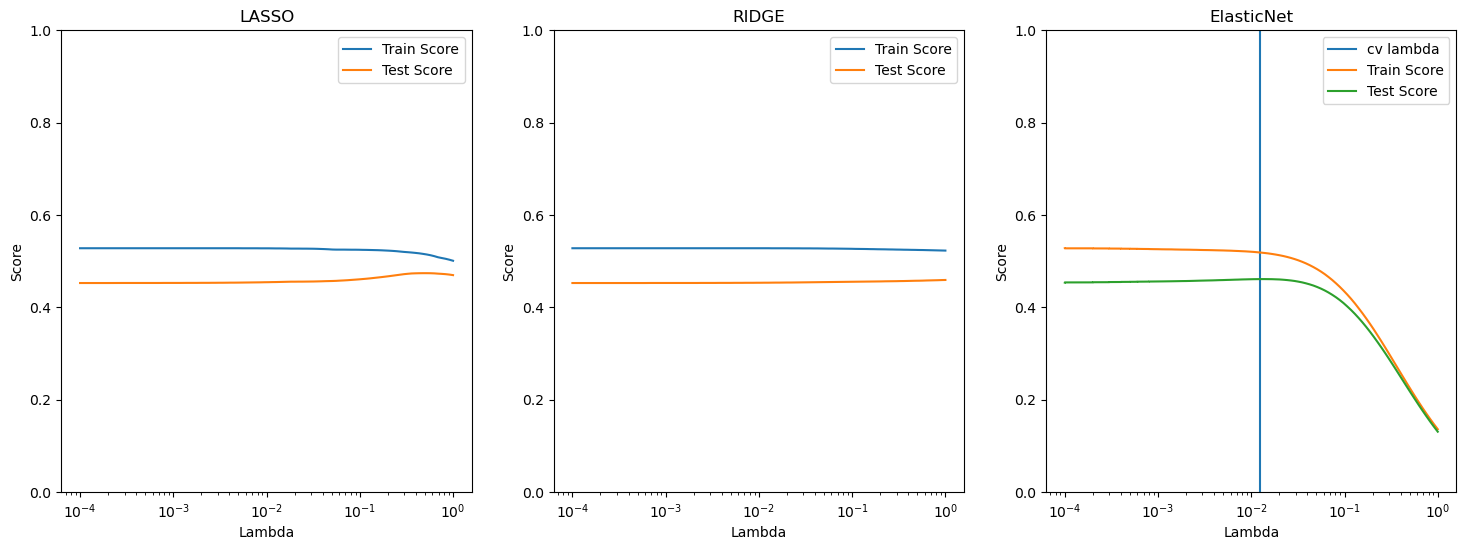

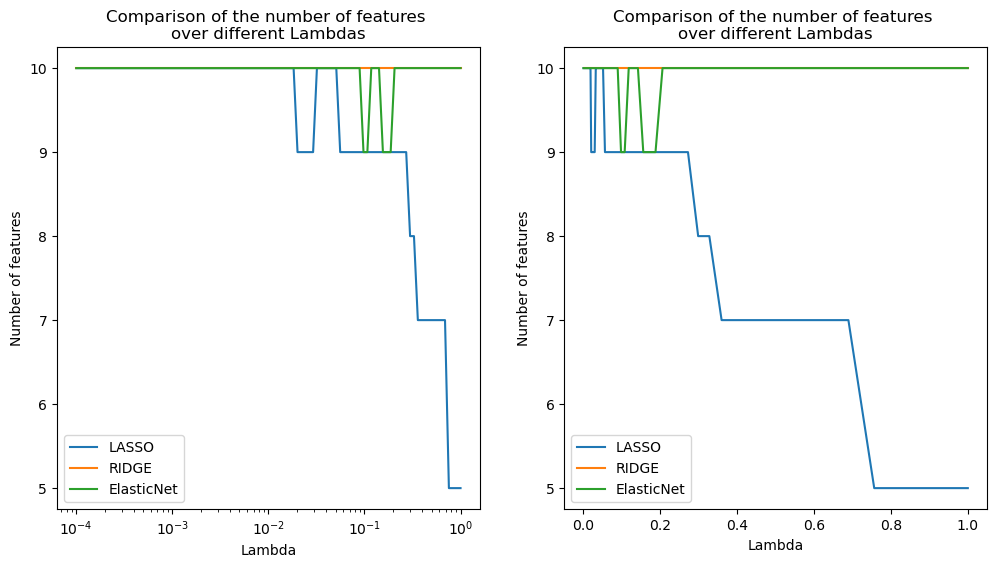

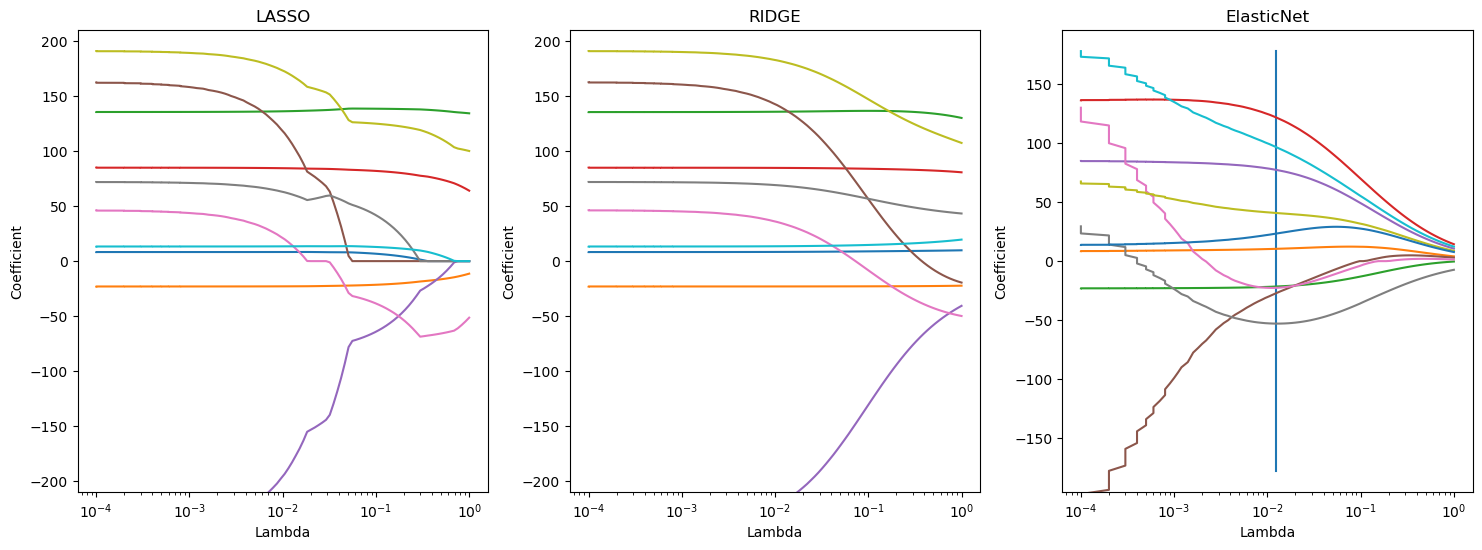

Train Score: 0.5228
Test Score: 0.4596
L1 Ratio: 0.8
Lambda: 0.0123


In [13]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target
feature_names = diabetes.feature_names
compare(X,y,feature_names)

/Users/wanjeans/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


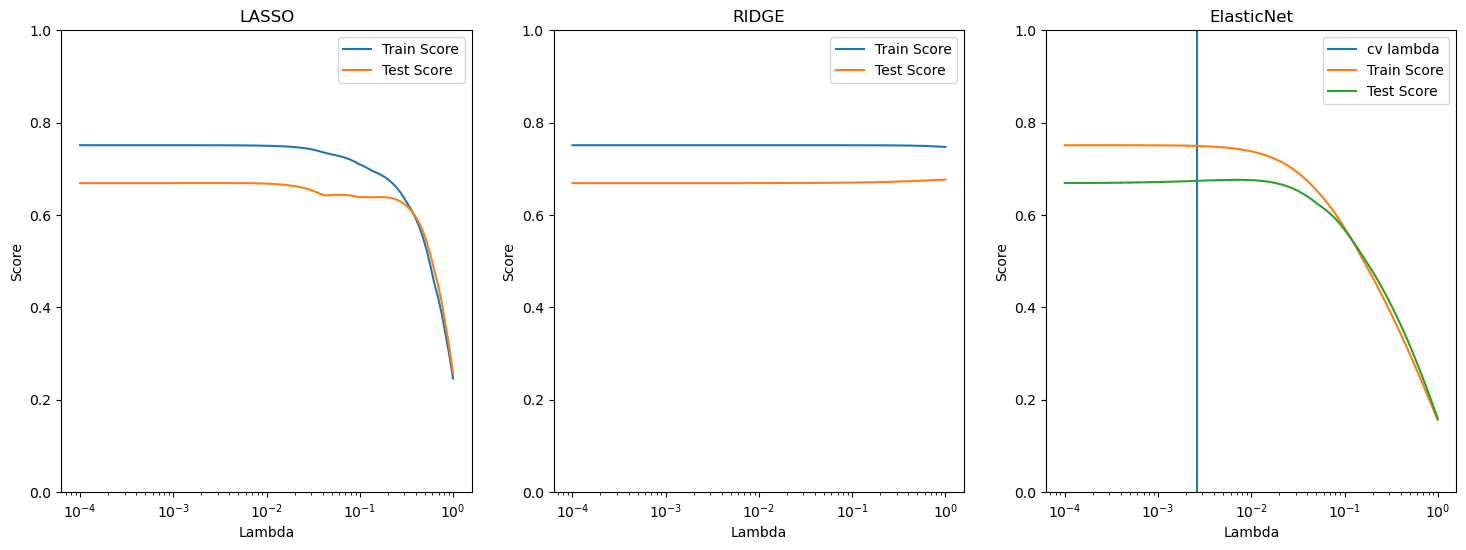

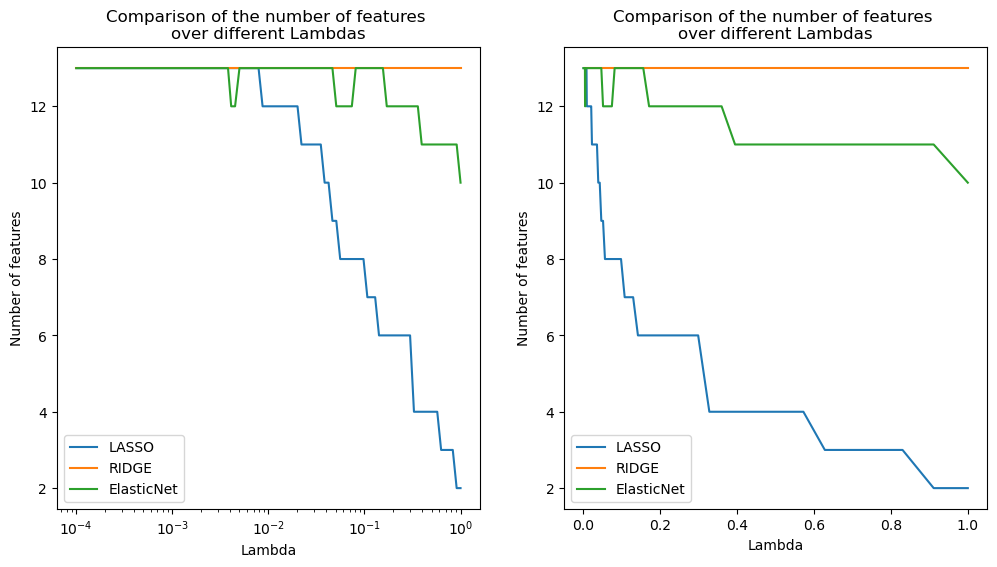

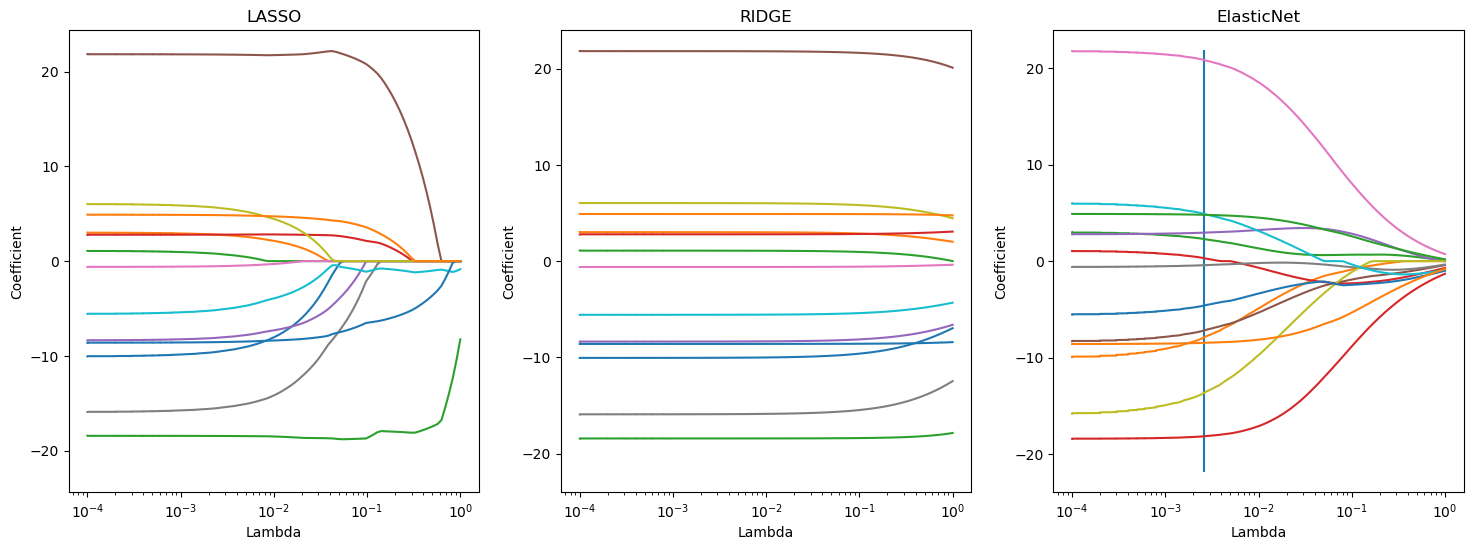

Train Score: 0.7495
Test Score: 0.6734
L1 Ratio: 0.6
Lambda: 0.0026


In [14]:
from sklearn.datasets import fetch_openml
import numpy as np
#wilt = fetch_openml('mnist_784', version=1, as_frame=True)
wilt = fetch_openml('boston', version=1, as_frame=True)
X = wilt.data
y = wilt.target
feature_names = wilt.feature_names
compare(X,y,feature_names)

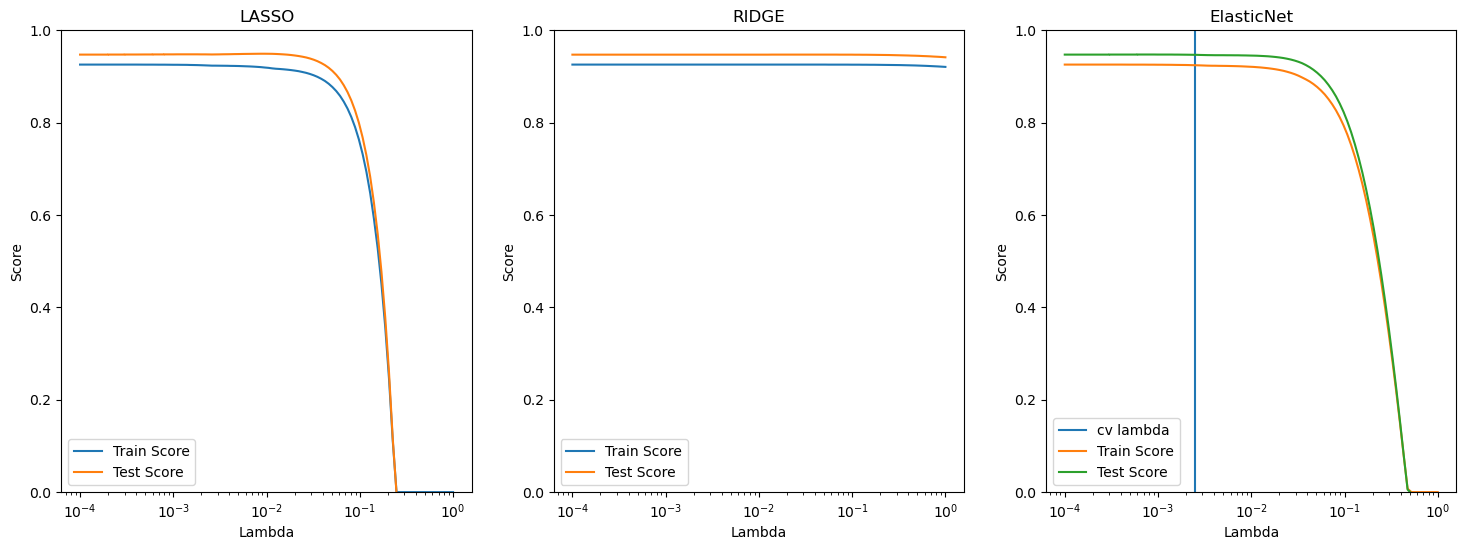

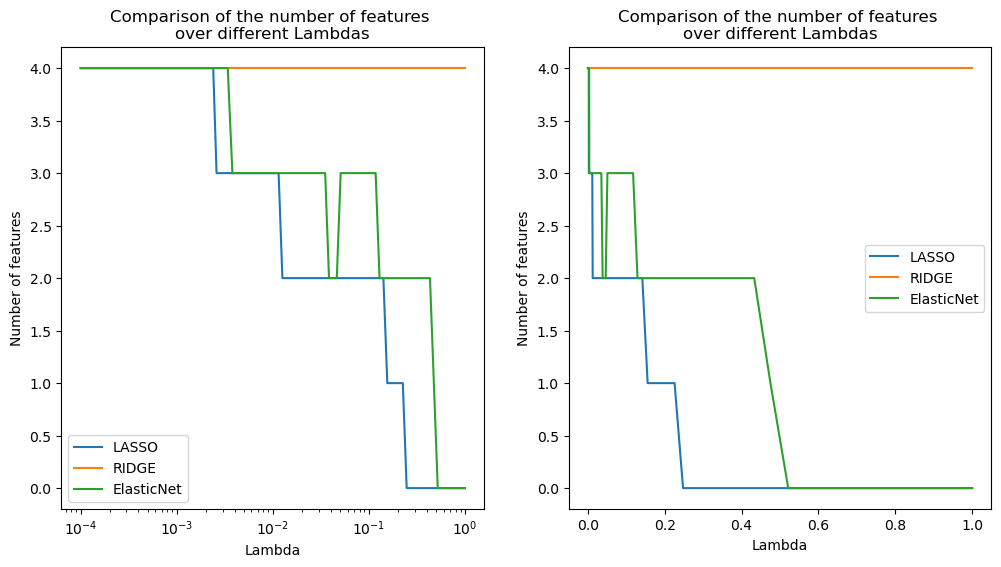

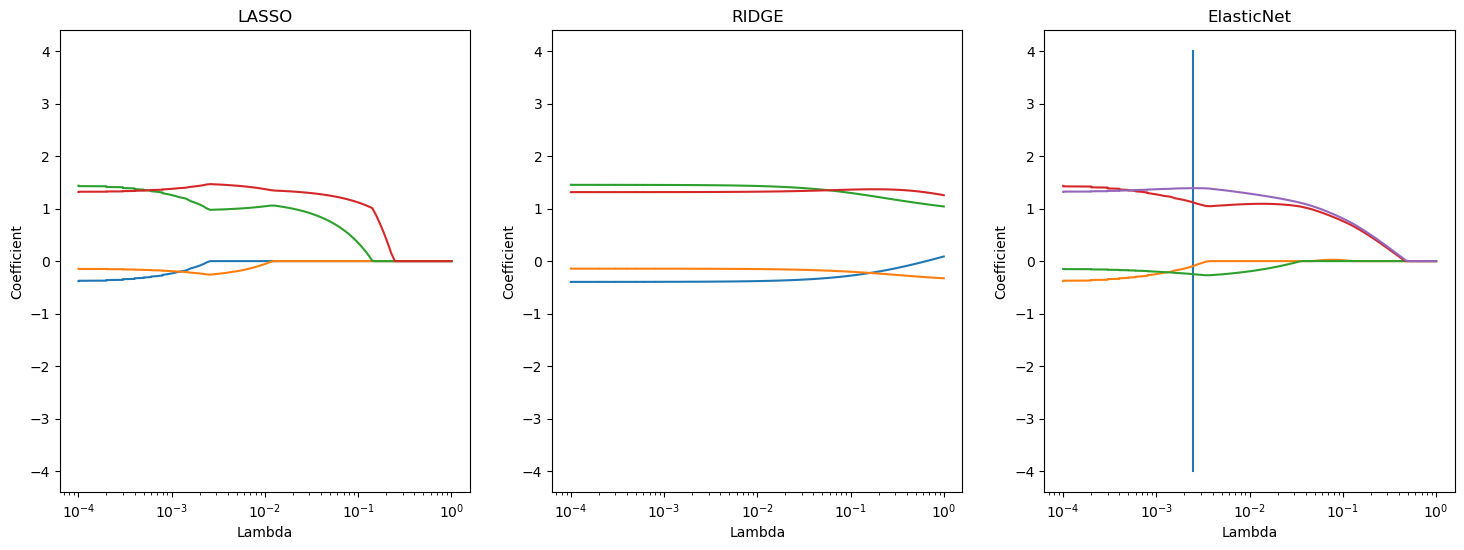

Train Score: 0.9244
Test Score: 0.9459
L1 Ratio: 0.1
Lambda: 0.0025


In [15]:
# Load the diabetes dataset
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
compare(X,y,feature_names)